# King County Housing Data Analysis

## Overview
A New York based housing devoloper is looking to expand their business westward and has decided to purchase property in King County, Washington. The company focuses only on complete rebuilds or ground-up construction. They have tasked us with performing a linear regression analysis in order to gain a better understanding of the impact of certain factors on the expected value of a home.

## <u>Business Understanding</u>

Model meant to inform stakeholders about the relationship between elements of a house and the value of that house

### Business Problem
* What is the impact of adjusting the square feet of living space on the expected home value
* *What is the impact of living in a particular zipcode



What is the impact of changing the number of bedrooms compared to the impact of changing the number of bathrooms

In [1]:
#from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor #for multicollinearity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## <u>Data Understanding</u>

In [2]:
house_data = pd.read_csv('data/kc_house_data.csv')

#### Map Try

In [3]:
house_data['price_per_square'] = house_data['price']/house_data['sqft_living']

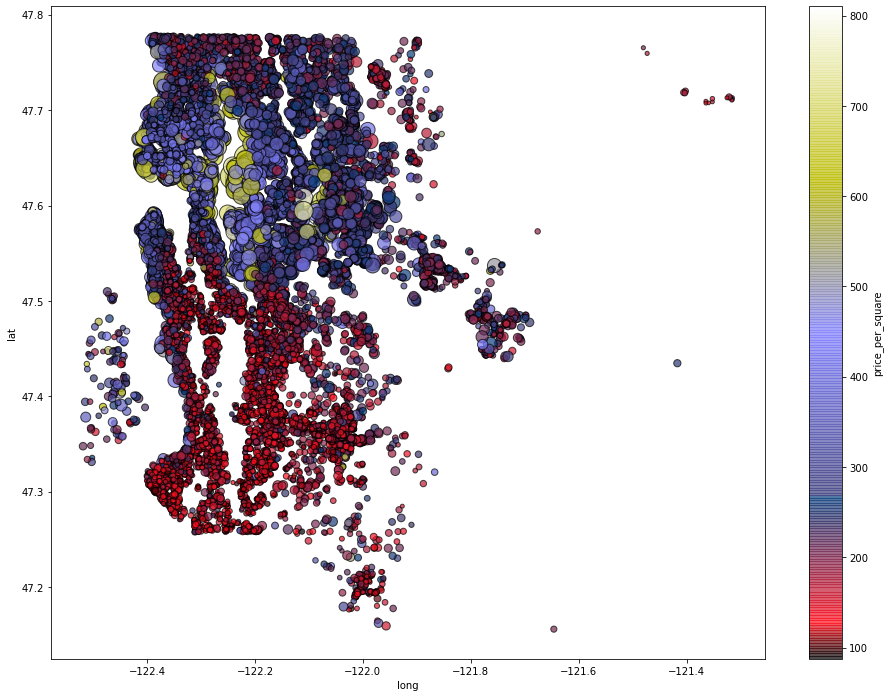

In [4]:
bfig, ax = plt.subplots(figsize=(16,12))
house_data.plot(kind='scatter', x='long', y='lat', edgecolor='black', alpha=0.7, c='price_per_square',
                s=house_data['price']/10000, ax=ax, cmap=plt.get_cmap('gist_stern'), colorbar=True);

<AxesSubplot:xlabel='long', ylabel='lat'>

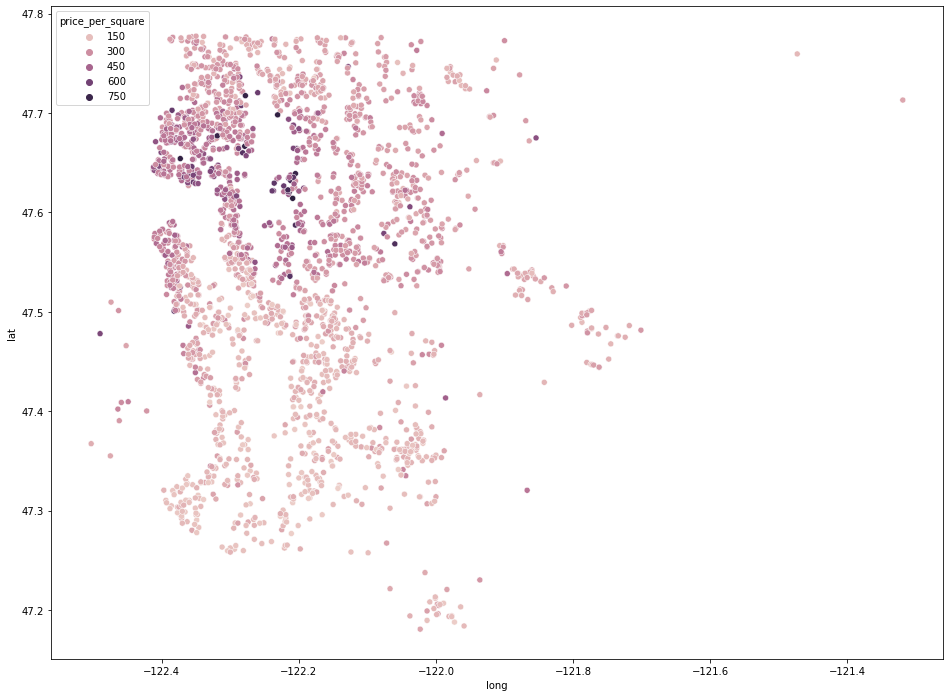

In [5]:
fig, ax = plt.subplots(figsize=(16,12))
sns.scatterplot(data=house_data[house_data.waterfront.isna()], x='long', y='lat', hue='price_per_square')

<AxesSubplot:xlabel='long', ylabel='lat'>

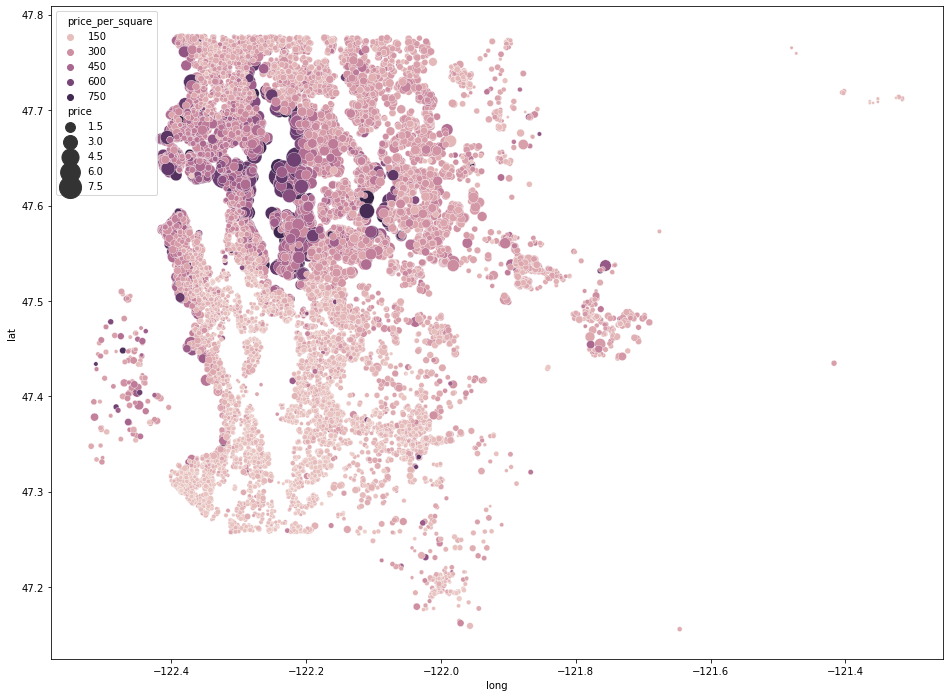

In [6]:
fig, ax = plt.subplots(figsize=(16,12))
sns.scatterplot(data=house_data, x='long', y='lat', size=(house_data.price/1000000), sizes=(5,500),
                hue='price_per_square')

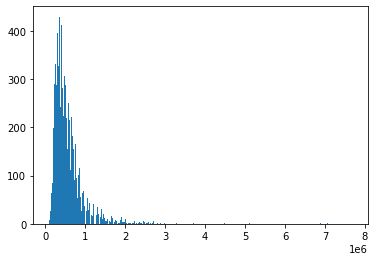

In [7]:
plt.hist(house_data.price, bins=1000);

In [8]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_square
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,188.050847
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,209.338521
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,233.766234
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,308.163265
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,303.571429


In [9]:
list(house_data.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price_per_square']

In [10]:
house_data['price'][0] / house_data['sqft_living'][0]

188.05084745762713

In [11]:
house_data.zipcode.value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [12]:
house_data = house_data.groupby('zipcode')

In [13]:
house_data

In [14]:
house_data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_square
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,188.050847
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,209.338521
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,233.766234
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,308.163265
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,303.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,3625049014,8/29/2014,2950000.0,4,3.50,4860,23885,2.0,0.0,0.0,...,4860,0.0,1996,0.0,98039,47.6172,-122.230,3580,16054,606.995885
3757,2540700110,2/12/2015,1910000.0,4,3.50,4210,18564,2.0,0.0,0.0,...,4210,0.0,2001,0.0,98039,47.6206,-122.225,3520,18564,453.681710
4073,3262300940,11/7/2014,875000.0,3,1.00,1220,8119,1.0,0.0,0.0,...,1220,0.0,1955,NaN,98039,47.6328,-122.236,1910,8119,717.213115
4074,3262300940,2/10/2015,940000.0,3,1.00,1220,8119,1.0,0.0,0.0,...,1220,0.0,1955,NaN,98039,47.6328,-122.236,1910,8119,770.491803


In [15]:
house_data.describe()

id                                                         \
         count          mean           std          min           25%   
zipcode                                                                 
98001    361.0  4.651274e+09  2.606276e+09  128500260.0  2.895550e+09   
98002    199.0  4.850894e+09  3.039520e+09    1000102.0  1.921059e+09   
98003    280.0  4.674182e+09  2.560663e+09  100500020.0  2.413301e+09   
98004    317.0  4.394237e+09  3.196276e+09  249000115.0  1.561600e+09   
98005    168.0  4.961872e+09  3.277385e+09  324059112.0  1.927675e+09   
...        ...           ...           ...          ...           ...   
98177    255.0  3.934998e+09  2.887379e+09  106000044.0  1.124000e+09   
98178    262.0  4.291467e+09  2.736750e+09    3800008.0  2.151450e+09   
98188    136.0  4.481851e+09  2.743040e+09   41000454.0  1.771400e+09   
98198    280.0  5.152291e+09  2.744405e+09  379000051.0  2.560803e+09   
98199    317.0  3.410035e+09  2.466593e+09  207500012.0  1.370802e+09   

                                                   price                ...  \
                  50%           75%           max  count          mean  ...   
zipcode                                                                 ...   
98001    3.751605e+09  6.648770e+09  9.543001e+09  361.0  2.811949e+05  ...   
98002    5.125400e+09  7.349400e+09  9.500900e+09  199.0  2.342840e+05  ...   
98003    4.322300e+09  7.212651e+09  9.358400e+09  280.0  2.941113e+05  ...   
98004    3.860400e+09  7.963900e+09  9.809000e+09  317.0  1.356524e+06  ...   
98005    3.504980e+09  7.971300e+09  9.560700e+09  168.0  8.102897e+05  ...   
...               ...           ...           ...    ...           ...  ...   
98177    3.585900e+09  7.277100e+09  9.540100e+09  255.0  6.764194e+05  ...   
98178    3.969300e+09  7.634650e+09  9.368700e+09  262.0  3.106128e+05  ...   
98188    5.379802e+09  5.632650e+09  9.198600e+09  136.0  2.890783e+05  ...   
98198    5.083050e+09  7.737713e+09  9.537200e+09  280.0  3.028967e+05  ...   
98199    2.770602e+09  6.662000e+09  9.241900e+09  317.0  7.921879e+05  ...   

        sqft_lot15           price_per_square                          \
               75%       max            count        mean         std   
zipcode                                                                 
98001      12610.0   57934.0            361.0  151.347966   33.868772   
98002       8552.0   69993.0            199.0  151.174091   32.254910   
98003      10200.0   60513.0            280.0  157.113414   31.877620   
98004      15732.0   44584.0            317.0  475.609615  123.934669   
98005      20883.5  167378.0            168.0  314.966998   65.455035   
...            ...       ...              ...         ...         ...   
98177      10690.5  128066.0            255.0  292.982095   93.496885   
98178       8958.5   78408.0            262.0  189.172528   73.745294   
98188      10662.5   18333.0            136.0  169.007306   41.126869   
98198       9769.0   70973.0            280.0  178.434333   61.513135   
98199       6000.0   21074.0            317.0  376.659850   98.243805   

                                                                     
                min         25%         50%         75%         max  
zipcode                                                              
98001     88.698630  127.853881  147.141345  169.354839  395.238095  
98002     87.588235  125.950388  147.177419  170.296627  247.474747  
98003     88.150289  136.324451  154.819246  174.177038  258.119658  
98004    241.573034  386.974790  456.944444  558.823529  792.105263  
98005    148.750993  275.507846  316.340431  353.243978  561.224490  
...             ...         ...         ...         ...         ...  
98177    139.534884  230.743019  272.074830  334.935897  735.294118  
98178     89.447236  143.157955  176.623459  209.798712  717.391304  
98188     88.541667  138.426858  163.897059  195.988806  287.837838  
98198     88.541667

In [16]:
house_data.info()

AttributeError: 'DataFrameGroupBy' object has no attribute 'info'

In [ ]:
house_data.isna().sum()

In [17]:
## Reorder columns so that the target variable is the first column
house_data.drop('id', axis=1, inplace=True)
column_headers = list(house_data.columns)
column_headers = [column_headers[1]] + column_headers[:1] + column_headers[2:]
house_data = house_data[column_headers]

AttributeError: 'DataFrameGroupBy' object has no attribute 'drop'

#### Data Cleaning

As we are only concerned with new construction we will remove data of houses not built within the last five years.

In [9]:
house_data = house_data[(house_data.yr_built <= 2015) & (house_data.yr_built >= 2011)]

In [1]:
## We then remove the data that lies beyond three standard deviations of the average price so that
## our model isn't explaining these outliers.

## Use +/- IQR*1.5
mean_plus_three_std = house_data.price.mean() + 3 * house_data.price.std()
mean_minus_three_std = house_data.price.mean() - 3 * house_data.price.std()
house_data = house_data[(house_data.price <= mean_plus_three_std) &\
                        (house_data.price >= mean_minus_three_std)]

NameError: name 'house_data' is not defined

In [11]:
house_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.073000e+03,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,954.0,1071.000000,1073.0,1073.000000,1073.000000,1073.000000,877.0,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,6.082070e+05,3.674744,2.714352,2503.399814,6164.493010,2.082479,0.0,0.094304,3.0,8.412861,2351.771668,2013.180801,0.0,98072.378378,47.535338,-122.181638,2255.371855,6270.747437
std,2.868818e+05,0.833916,0.559912,836.697599,9892.680959,0.376490,0.0,0.465115,0.0,0.855242,812.216565,1.118420,0.0,46.743389,0.136861,0.156173,749.968210,8734.333577
min,1.550000e+05,1.000000,1.000000,710.000000,609.000000,1.000000,0.0,0.000000,3.0,6.000000,710.000000,2011.000000,0.0,98001.000000,47.193700,-122.443000,700.000000,748.000000
25%,3.899500e+05,3.000000,2.500000,1770.000000,2820.000000,2.000000,0.0,0.000000,3.0,8.000000,1677.000000,2012.000000,0.0,98034.000000,47.451700,-122.317000,1620.000000,3600.000000
50%,5.450000e+05,4.000000,2.500000,2490.000000,4945.000000,2.000000,0.0,0.000000,3.0,8.000000,2350.000000,2014.000000,0.0,98059.000000,47.545000,-122.193000,2150.000000,5001.000000
75%,7.600000e+05,4.000000,3.000000,3087.000000,6558.000000,2.000000,0.0,0.000000,3.0,9.000000,2900.000000,2014.000000,0.0,98108.000000,47.653600,-122.059000,2730.000000,6723.000000
max,1.770000e+06,7.000000,4.750000,5860.000000,144619.000000,3.000000,0.0,4.000000,3.0,11.000000,4800.000000,2015.000000,0.0,98199.000000,47.776000,-121.364000,5790.000000,131007.000000


In [12]:
correlation_of_variable = house_data.corr()

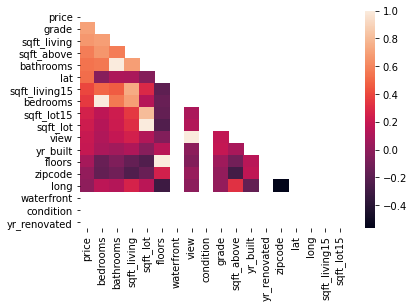

In [13]:
correlation_of_variable = correlation_of_variable.sort_values(by='price', ascending=False)
mask = np.triu(np.ones_like(correlation_of_variable, dtype=np.bool))
sns.heatmap(correlation_of_variable, mask=mask, color='red');

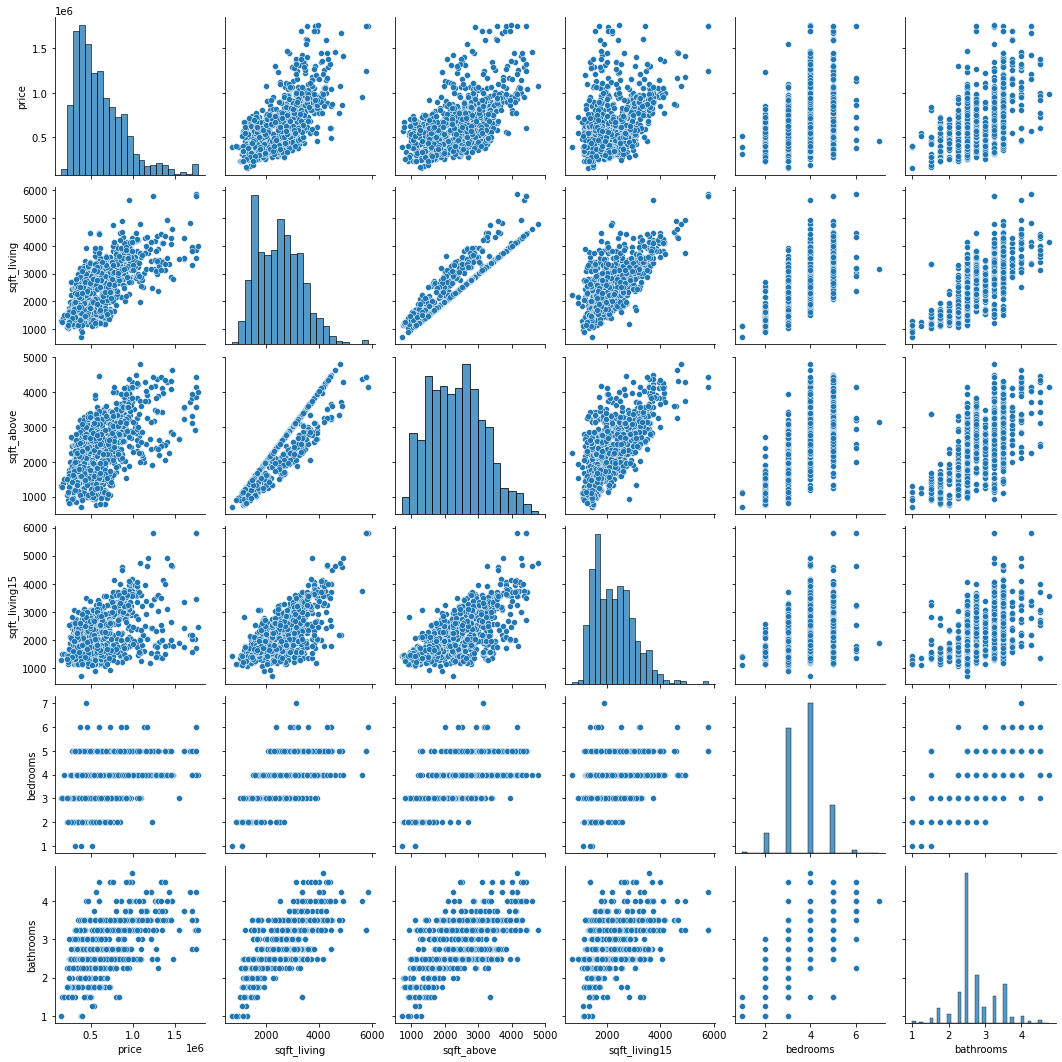

In [14]:
positively_correlated_values = house_data[['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'bedrooms', 'bathrooms']]
sns.pairplot(positively_correlated_values)

In [15]:
positively_correlated_values.describe()

,price,sqft_living,sqft_above,sqft_living15,bedrooms,bathrooms
count,1.073000e+03,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,6.082070e+05,2503.399814,2351.771668,2255.371855,3.674744,2.714352
std,2.868818e+05,836.697599,812.216565,749.968210,0.833916,0.559912
min,1.550000e+05,710.000000,710.000000,700.000000,1.000000,1.000000
25%,3.899500e+05,1770.000000,1677.000000,1620.000000,3.000000,2.500000
50%,5.450000e+05,2490.000000,2350.000000,2150.000000,4.000000,2.500000
75%,7.600000e+05,3087.000000,2900.000000,2730.000000,4.000000,3.000000
max,1.770000e+06,5860.000000,4800.000000,5790.000000,7.000000,4.750000


In [16]:
first_model_DataFrame = house_data[['price', 'sqft_living']].copy()
first_model = ols(formula='price ~ sqft_living', data=first_model_DataFrame)
first_model_results = first_model.fit()
first_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     849.4
Date:                Thu, 20 May 2021   Prob (F-statistic):          5.72e-138
Time:                        22:14:49   Log-Likelihood:                -14693.
No. Observations:                1073   AIC:                         2.939e+04
Df Residuals:                    1071   BIC:                         2.940e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.735e+04   2.07e+04      1.809      0.071   -3171.184    7.79e+04
sqft_living   228.0327      7.824     29.145      0.000     212.680     243.385
==============================================================================
Omnibus:                      158.773   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.393
Skew:                           0.948   Prob(JB):                     5.24e-59
Kurtosis:                       4.552   Cond. No.                     8.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

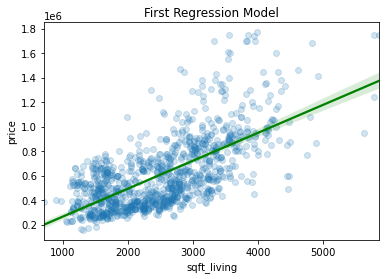

In [17]:
sns.regplot(x='sqft_living', y='price', data=first_model_DataFrame, scatter_kws={'alpha':0.2}, line_kws={'color':'green'});
plt.title('First Regression Model', size=12);

### First Model Evaluation

The summary of this model indicates that:
* 44.2% of the variance in our dependent variable is explained by the variance in our independent variable.
* Only the coefficient for the square footage of living space is statistically significant at an alpha of 0.05
* One unit of change in the square footage of living space has an effect of $228.03

 #### Assumption of Linearity<br>&emsp;(for first model)

In [18]:
rainbow_p_value = linear_rainbow(first_model_results)[1]
print('Rainbow p-value:', rainbow_p_value)

Rainbow p-value: 0.011962700445955435


The returned p value indicates that we reject the null hypothesis and therefore, violate the assumption of linearity.

#### Assumption of Normality<br>&emsp;(for first model)

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>]], dtype=object)

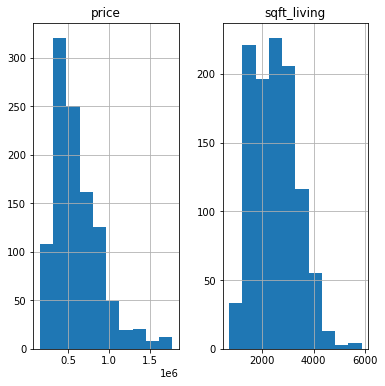

In [19]:
first_model_DataFrame.hist(figsize = [6,6])

<ipython-input-20-fd0144d54077>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


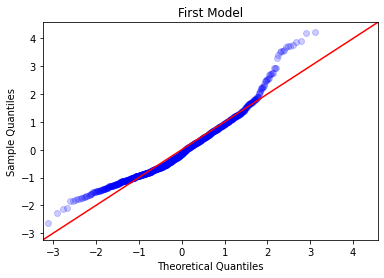

In [20]:
residuals = first_model_results.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
plt.title('First Model', size=12);
fig.show()

The visualizations above display a skewed right distribution.<br>
The probability value returned by the Jarque-Bera indicates that we reject the null hypothesis and therefore,<br>
violate the assumption of normality.

#### Assumption of Homoscadasticity<br>&emsp;(for first model)

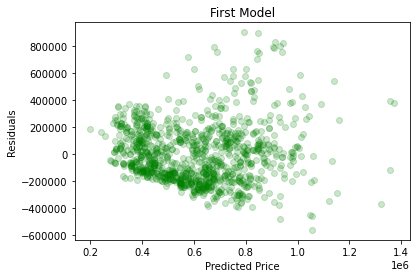

In [21]:
y_hat = first_model_results.predict()
fig1, ax1 = plt.subplots()
ax1.scatter(x=y_hat, y=residuals, color='green', alpha=0.2)
ax1.set(xlabel='Predicted Price',
        ylabel='Residuals')
plt.title('First Model', size=12);

### Second Model Evaluation

In [22]:
log_target = pd.DataFrame([])
log_target['log_price'] = np.log(first_model_DataFrame['price'])
log_target['sqft_living'] = first_model_DataFrame['sqft_living']

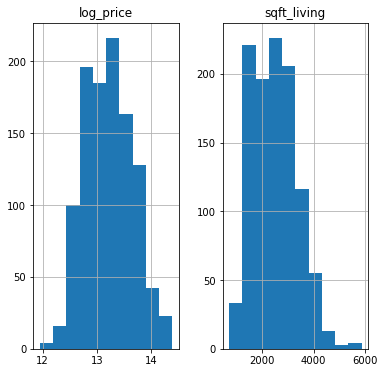

In [23]:
log_target.hist(figsize = [6,6]);

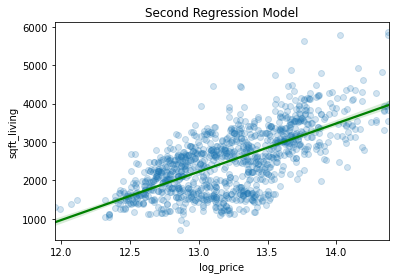

In [24]:
sns.regplot(x='log_price', y='sqft_living', data=log_target, scatter_kws={'alpha':0.2}, line_kws={'color':'green'});
plt.title('Second Regression Model', size=12);

In [25]:
second_model_DataFrame = log_target.copy()
second_model_DataFrame.dropna(inplace=True)
second_model_ols = ols(formula='log_price ~ sqft_living', data = second_model_DataFrame)
ssm_results = second_model_ols.fit()

In [26]:
ssm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     842.0
Date:                Thu, 20 May 2021   Prob (F-statistic):          4.54e-137
Time:                        22:14:51   Log-Likelihood:                -333.25
No. Observations:                1073   AIC:                             670.5
Df Residuals:                    1071   BIC:                             680.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3427      0.032    387.721      0.000      12.280      12.405
sqft_living     0.0003   1.21e-05     29.017      0.000       0.000       0.000
==============================================================================
Omnibus:                       71.035   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.772
Skew:                           0.151   Prob(JB):                     5.65e-07
Kurtosis:                       2.256   Cond. No.                     8.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary of this model indicates that:
* 46.4% of the variance in our dependent variable is explained by the variance in our independent variable,<br>
an improvement from our first model.
* Both coefficients are statistically significant at an alpha of 0.05
* To scale our data after the log transformation of the target variable we interpret the sqft_living coefficient<br>
to mean that a one unit change in the square footage of living space has an effect of .04% change in price.

#### Assumption of Linearity<br>&emsp;(for second model)

In [27]:
second_rainbow_p_value = linear_rainbow(ssm_results)[1]
print('Rainbow p-value:', second_rainbow_p_value)

Rainbow p-value: 0.25489070424426113


The returned p value implies that we again reject the null hypothesis and therefore, we do not meet the assumption of linearity.

#### Assumption of Normality<br>&emsp;(for second model)

The p value returned by the Jarque-Bera indicates that we reject the null hypothesis and therefore,<br>
also violate the assumption of normality. However, visually our data seems to far more closely fit a standard distribution<br> when compared to our first model.

<ipython-input-28-052d115e8f62>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


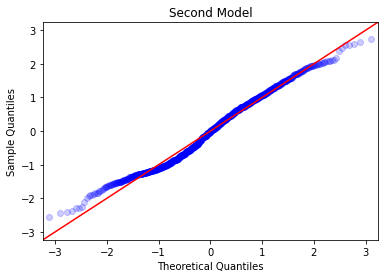

In [28]:
residuals = ssm_results.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
plt.title('Second Model', size=12);
fig.show()

#### Assumption of Homoscadasticity<br>&emsp;(for second model)

In [29]:
y = second_model_DataFrame['log_price']
y_hat = ssm_results.predict()

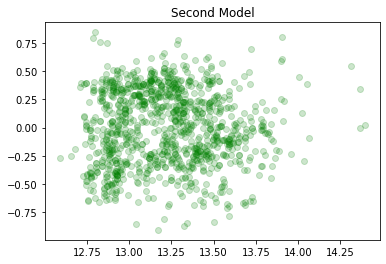

In [39]:
fig1,ax1 = plt.subplots()
ax1.scatter(x=y_hat, y=y_hat-y, color='green', alpha=0.2)
plt.title('Second Model', size=12);

This scatterplot seems to show homoscedasticity, failing to reject the null hypothesis and therefore, meeting the assumption of homoscedasticity.

## Model 3

In [31]:
third_model_DataFrame = pd.DataFrame([])
third_model_DataFrame = house_data[['sqft_living', 'bedrooms']].copy()
third_model_DataFrame['log_price'] = log_target['log_price']
third_model_DataFrame.dropna(inplace=True)
third_model = ols(formula='log_price ~ sqft_living + bedrooms', data=third_model_DataFrame)
third_model_results = third_model.fit()
third_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     459.4
Date:                Thu, 20 May 2021   Prob (F-statistic):          9.22e-145
Time:                        22:14:51   Log-Likelihood:                -311.89
No. Observations:                1073   AIC:                             629.8
Df Residuals:                    1070   BIC:                             644.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.5539      0.045    280.681      0.000      12.466      12.642
sqft_living     0.0004   1.64e-05     25.943      0.000       0.000       0.000
bedrooms       -0.1083      0.016     -6.594      0.000      -0.140      -0.076
==============================================================================
Omnibus:                       44.722   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.463
Skew:                           0.154   Prob(JB):                     1.33e-05
Kurtosis:                       2.361   Cond. No.                     1.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third Model Evaluation

The summary of this model indicates that:
* 49.3% of the variance in our dependent variable is explained by the variance in our independent variables.
* All three coefficents are statistically significant at an alpha of 0.05
* Again scaling our data we interpret the 

#### Assumption of Linearity<br>&emsp;(for third model)

In [32]:
third_rainbow_p_value = linear_rainbow(third_model_results)[1]
print('Rainbow p-value:', third_rainbow_p_value)

Rainbow p-value: 0.18813803174603413


The returned p value indicates that we reject the null hypothesis and therefore, are still violating the assumption of linearity.

#### Assumption of Normality<br>&emsp;(for third model)

array([[<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'log_price'}>, <AxesSubplot:>]],
      dtype=object)

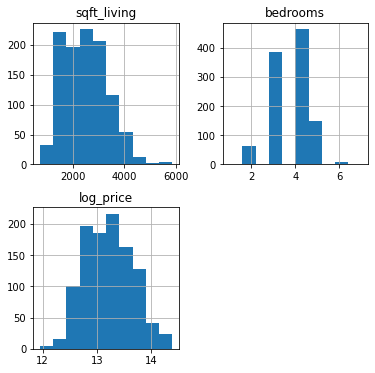

In [33]:
third_model_DataFrame.hist(figsize = [6,6])

<ipython-input-34-4c24c9ce1386>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


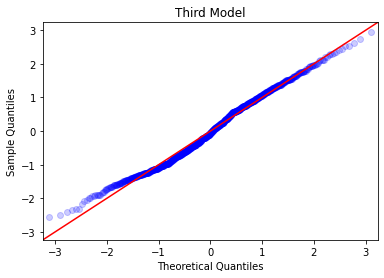

In [34]:
third_residuals = third_model_results.resid
fig = sm.graphics.qqplot(third_residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
plt.title('Third Model', size=12);
fig.show()

The probability value returned by the Jarque-Bera indicates that we reject the null hypothesis and therefore,<br>
are again violating the assumption of normality.

#### Assumption of Homoscadasticity<br>&emsp;(for third model)

In [35]:
y3 = third_model_DataFrame['log_price']
y3_hat = third_model_results.predict()

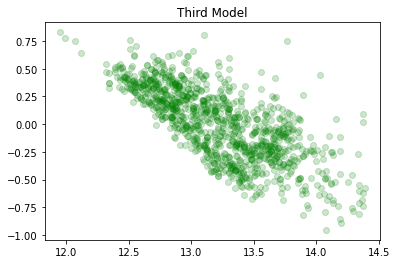

In [40]:
fig3,ax3 = plt.subplots()
ax3.scatter(x=y3, y=y3_hat-y3, color='green', alpha=0.2)
plt.title('Third Model', size=12);

This scatterplot shows heteroscedasticity, rejecting the null hypothesis and therefore, violating the assumption of homoscedasticity.

#### Independence<br>&emsp;(for third model)

In [37]:
rows = third_model_DataFrame[['sqft_living','bedrooms']].values
variance_inflation_DataFrame = pd.DataFrame()
variance_inflation_DataFrame['vif'] = [variance_inflation_factor(rows, i) for i in range(2)]

In [38]:
variance_inflation_DataFrame

,vif
0,19.057606
1,19.057606


The condition number returned in the regression results indicates a strong multicollinearity.